In [ ]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler,OneHotEncoder,StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.model_selection import cross_val_score,cross_val_predict,train_test_split,cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import xgboost as xgb
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,precision_score,recall_score,f1_score,roc_curve,roc_auc_score, accuracy_score
from datetime import datetime

In [ ]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))
        return f"{thour} hours {tmin} minutes and {np.round(tsec, 2)} seconds."

# **Load Dataset**

In [ ]:
# import dataset
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/adult-all.csv'
df_raw = pd.read_csv(url,names=["Age", "Workclass", "Final Weight", "Education", "Education Number of Years", "Marital-status",
                            "Occupation", "Relationship", "Race", "Sex", "Capital-gain", "Capital-loss","Hours-per-week", "Native-country",
                            "Target"], na_values='?')

In [ ]:
df=df_raw.copy()
# let´s drop rows with missing data
df = df.dropna()
# label encode target
mapping={"<=50K":0,
         '>50K':1}
df.loc[:,"Target"]=df["Target"].map(mapping)
# identify feature list
features=[f for f in df.columns if f not in ("Target")]
# select categorical and numerical features
cat_ix = df[features].select_dtypes(include=['object', 'bool']).columns
num_ix = df[features].select_dtypes(include=['int64', 'float64']).columns
# split the dataframe into X and y
X=df.loc[:, df.columns != 'Target']
y=df.loc[:,'Target']
# perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


# **Model HP-grids**

In [ ]:
# DEFINING HP GRIDS
# parameter grid for XGB
learning_rate_ = [.1,.3,.5]
n_estimators_ = [50,100,200]
max_depth_=[3,6]
grid_xgb = dict(learning_rate=learning_rate_,
            n_estimators=n_estimators_,
            max_depth=max_depth_)
# parameter grid for KNN
n_neighbors_=[5,10,50]
grid_knn = dict(n_neighbors=n_neighbors_)
# parameter grid for SVM
C_=[0.01,1.0,10.0]
grid_svm = {'C':C_}
# parameter grid for QDA
reg_param_=[0.0]
grid_qda=dict(reg_param=reg_param_)
# parameter grid for LogRes
C_=[0.01,0.1,1.0,10.0]
penalty_=["l1","l2"]
grid_lr=dict(C=C_,penalty=penalty_)
# parameter grid for RFs
n_estimators_=[100,300]
max_depth_=[5,8,None]
grid_rf=dict(n_estimators=n_estimators_,max_depth=max_depth_)
# scoring metrics
scoring = {'acc': 'accuracy',
          'prec': 'precision',
          'rec': 'recall',
           'f1':'f1'}
# initialize metric lists
accuracy=[]
precision=[]
recall=[]
f1=[]
auc=[]
names=[]
runtime=[]
cv_acc=[]
cv_prec=[]
cv_rec=[]
cv_f1=[]

# **XGB**

In [ ]:
model=xgb.XGBClassifier(n_jobs=-1)
name="xgb"
grid=grid_xgb
# feature transformation for numericals
num_pipeline=Pipeline([("minmax_scaler",MinMaxScaler())])
# apply MinMax to numericals and OneHot to categoricals
transformation_pipeline=ColumnTransformer([("num",num_pipeline,num_ix),
                                           ("cat",OneHotEncoder(handle_unknown = "ignore"),cat_ix)])
# NESTED CROSS-VALIDATION: inner folds for HP search, outer for generaliz.error
# inner kfold for hp-search
inner_kfold=StratifiedKFold(n_splits=3,shuffle=True,random_state=1)
# invoke grid-search CV to search for best hp
gscv= GridSearchCV(estimator=model,
                param_grid = grid,
                cv=inner_kfold,
                scoring='f1',
                verbose=0,
                n_jobs=-1,
                refit=True)
# define model pipeline: data transformation then grid-search
model_pipeline=Pipeline([("transformer",transformation_pipeline),
                         ("model",gscv)])
# perform cross-validation to estimate generaliz.error
skfold=StratifiedKFold(n_splits=5)
start_time = timer(None)
scores = cross_validate(model_pipeline, X_train, y_train, scoring=scoring, cv=skfold, n_jobs=-1)
time_off=timer(start_time)
# cross-validation metrics
acc_cv=np.mean(scores['test_acc'])
cv_acc.append(acc_cv)
f1_cv=np.mean(scores['test_f1'])
cv_f1.append(f1_cv)
prec_cv=np.mean(scores['test_prec'])
cv_prec.append(prec_cv)
rec_cv=np.mean(scores['test_rec'])
cv_rec.append(rec_cv)
# fit pipeline on (X_train,y_train) to return best model
model_pipeline.fit(X_train,y_train)
# make preditions using best_model
predictions=model_pipeline.predict(X_test)
# store classification metrics
names.append(name)
accuracy.append(accuracy_score(y_test,predictions))
precision.append(precision_score(y_test,predictions))
recall.append(recall_score(y_test,predictions))
f1.append(f1_score(y_test,predictions))
auc.append(roc_auc_score(y_test,model_pipeline.predict_proba(X_test)[:,1]))
runtime.append(time_off)
print("################################################")
print("CROSS-VALIDATION METRICS")
print(f"CV Accuracy for {name}: {np.round(acc_cv,3)}")
print(f"CV Precision for {name}: {np.round(prec_cv,3)}")
print(f"CV Recall for {name}: {np.round(rec_cv,3)}")
print(f"CV F1 for {name}: {np.round(f1_cv,3)}")
print("################################################")


 Time taken: 0 hours 8 minutes and 31.03 seconds.
################################################
CROSS-VALIDATION METRICS
CV Accuracy for xgb: 0.869
CV Precision for xgb: 0.777
CV Recall for xgb: 0.655
CV F1 for xgb: 0.711
################################################


# **KNN**

In [ ]:
model=KNeighborsClassifier()
name="knn"
grid=grid_knn
# feature transformation for numericals
num_pipeline=Pipeline([("minmax_scaler",MinMaxScaler())])
# apply MinMax to numericals and OneHot to categoricals
transformation_pipeline=ColumnTransformer([("num",num_pipeline,num_ix),
                                           ("cat",OneHotEncoder(handle_unknown = "ignore"),cat_ix)])
# NESTED CROSS-VALIDATION: inner folds for HP search, outer for generaliz.error
# inner kfold for hp-search
inner_kfold=StratifiedKFold(n_splits=3,shuffle=True,random_state=1)
# invoke grid-search CV to search for best hp
gscv= GridSearchCV(estimator=model,
                param_grid = grid,
                cv=inner_kfold,
                scoring='f1',
                verbose=0,
                n_jobs=-1,
                refit=True)
# define model pipeline: data transformation then grid-search
model_pipeline=Pipeline([("transformer",transformation_pipeline),
                         ("model",gscv)])
# perform cross-validation to estimate generaliz.error
skfold=StratifiedKFold(n_splits=5)
start_time = timer(None)
scores = cross_validate(model_pipeline, X_train, y_train, scoring=scoring, cv=skfold, n_jobs=-1)
time_off=timer(start_time)
# cross-validation metrics
acc_cv=np.mean(scores['test_acc'])
cv_acc.append(acc_cv)
f1_cv=np.mean(scores['test_f1'])
cv_f1.append(f1_cv)
prec_cv=np.mean(scores['test_prec'])
cv_prec.append(prec_cv)
rec_cv=np.mean(scores['test_rec'])
cv_rec.append(rec_cv)
# fit pipeline on (X_train,y_train) to return best model
model_pipeline.fit(X_train,y_train)
# make preditions using best_model
predictions=model_pipeline.predict(X_test)
# store classification metrics
names.append(name)
accuracy.append(accuracy_score(y_test,predictions))
precision.append(precision_score(y_test,predictions))
recall.append(recall_score(y_test,predictions))
f1.append(f1_score(y_test,predictions))
auc.append(roc_auc_score(y_test,model_pipeline.predict_proba(X_test)[:,1]))
runtime.append(time_off)
print("################################################")
print("CROSS-VALIDATION METRICS")
print(f"CV Accuracy for {name}: {np.round(acc_cv,3)}")
print(f"CV Precision for {name}: {np.round(prec_cv,3)}")
print(f"CV Recall for {name}: {np.round(rec_cv,3)}")
print(f"CV F1 for {name}: {np.round(f1_cv,3)}")
print("################################################")

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning



 Time taken: 0 hours 6 minutes and 55.49 seconds.


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


################################################
CROSS-VALIDATION METRICS
CV Accuracy for knn: 0.832
CV Precision for knn: 0.693
CV Recall for knn: 0.57
CV F1 for knn: 0.626
################################################


# **Logistic Regression**

In [ ]:
from sklearn.preprocessing import FunctionTransformer
model=LogisticRegression()
name="lr"
grid=grid_lr
# feature transformation for numericals
num_pipeline=Pipeline([("minmax_scaler",MinMaxScaler())])
# apply MinMax to numericals and OneHot to categoricals
transformation_pipeline=ColumnTransformer([("num",num_pipeline,num_ix),
                                           ("cat",OneHotEncoder(handle_unknown = "ignore"),cat_ix)])
# NESTED CROSS-VALIDATION: inner folds for HP search, outer for generaliz.error
# inner kfold for hp-search
inner_kfold=StratifiedKFold(n_splits=3,shuffle=True,random_state=1)
# invoke grid-search CV to search for best hp
gscv= GridSearchCV(estimator=model,
                param_grid = grid,
                cv=inner_kfold,
                scoring='f1',
                verbose=0,
                n_jobs=-1,
                refit=True)
# define model pipeline: data transformation then grid-search
model_pipeline=Pipeline([("transformer",transformation_pipeline),
                         ("model",gscv)])
# perform cross-validation to estimate generaliz.error
skfold=StratifiedKFold(n_splits=5)
start_time = timer(None)
scores = cross_validate(model_pipeline, X_train, y_train, scoring=scoring, cv=skfold, n_jobs=-1)
time_off=timer(start_time)
# cross-validation metrics
acc_cv=np.mean(scores['test_acc'])
cv_acc.append(acc_cv)
f1_cv=np.mean(scores['test_f1'])
cv_f1.append(f1_cv)
prec_cv=np.mean(scores['test_prec'])
cv_prec.append(prec_cv)
rec_cv=np.mean(scores['test_rec'])
cv_rec.append(rec_cv)
# fit pipeline on (X_train,y_train) to return best model
model_pipeline.fit(X_train,y_train)
# make preditions using best_model
predictions=model_pipeline.predict(X_test)
# store classification metrics
names.append(name)
accuracy.append(accuracy_score(y_test,predictions))
precision.append(precision_score(y_test,predictions))
recall.append(recall_score(y_test,predictions))
f1.append(f1_score(y_test,predictions))
auc.append(roc_auc_score(y_test,model_pipeline.predict_proba(X_test)[:,1]))
runtime.append(time_off)
print("################################################")
print("CROSS-VALIDATION METRICS")
print(f"CV Accuracy for {name}: {np.round(acc_cv,3)}")
print(f"CV Precision for {name}: {np.round(prec_cv,3)}")
print(f"CV Recall for {name}: {np.round(rec_cv,3)}")
print(f"CV F1 for {name}: {np.round(f1_cv,3)}")
print("################################################")


 Time taken: 0 hours 0 minutes and 15.9 seconds.


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
12 fits failed out of a total of 24.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 449, in _check_solver
    % (solver, penalty)
ValueError: Solver

################################################
CROSS-VALIDATION METRICS
CV Accuracy for lr: 0.848
CV Precision for lr: 0.732
CV Recall for lr: 0.602
CV F1 for lr: 0.661
################################################


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


# **SVM**

In [ ]:
from sklearn.calibration import CalibratedClassifierCV
model=LinearSVC()
name="svm"
grid=grid_svm
# feature transformation for numericals
num_pipeline=Pipeline([("minmax_scaler",StandardScaler())])
# apply MinMax to numericals and OneHot to categoricals
transformation_pipeline=ColumnTransformer([("num",num_pipeline,num_ix),
                                           ("cat",OneHotEncoder(handle_unknown = "ignore"),cat_ix)])
# NESTED CROSS-VALIDATION: inner folds for HP search, outer for generaliz.error
# inner kfold for hp-search
inner_kfold=StratifiedKFold(n_splits=3,shuffle=True,random_state=1)
# invoke grid-search CV to search for best hp
gscv= GridSearchCV(estimator=model,
                param_grid = grid,
                cv=inner_kfold,
                scoring='f1',
                verbose=0,
                n_jobs=-1,
                refit=True)
gscv=CalibratedClassifierCV(gscv)
# define model pipeline: data transformation then grid-search
model_pipeline=Pipeline([("transformer",transformation_pipeline),
                         ("model",gscv)])
# perform cross-validation to estimate generaliz.error
skfold=StratifiedKFold(n_splits=5)
start_time = timer(None)
scores = cross_validate(model_pipeline, X_train, y_train, scoring=scoring, cv=skfold, n_jobs=-1)
time_off=timer(start_time)
# cross-validation metrics
acc_cv=np.mean(scores['test_acc'])
cv_acc.append(acc_cv)
f1_cv=np.mean(scores['test_f1'])
cv_f1.append(f1_cv)
prec_cv=np.mean(scores['test_prec'])
cv_prec.append(prec_cv)
rec_cv=np.mean(scores['test_rec'])
cv_rec.append(rec_cv)
# fit pipeline on (X_train,y_train) to return best model
model_pipeline.fit(X_train,y_train)
# make preditions using best_model
predictions=model_pipeline.predict(X_test)
# store classification metrics
names.append(name)
accuracy.append(accuracy_score(y_test,predictions))
precision.append(precision_score(y_test,predictions))
recall.append(recall_score(y_test,predictions))
f1.append(f1_score(y_test,predictions))
auc.append(roc_auc_score(y_test,model_pipeline.predict_proba(X_test)[:,1]))
runtime.append(time_off)
print("################################################")
print("CROSS-VALIDATION METRICS")
print(f"CV Accuracy for {name}: {np.round(acc_cv,3)}")
print(f"CV Precision for {name}: {np.round(prec_cv,3)}")
print(f"CV Recall for {name}: {np.round(rec_cv,3)}")
print(f"CV F1 for {name}: {np.round(f1_cv,3)}")
print("################################################")


 Time taken: 0 hours 4 minutes and 12.36 seconds.


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


################################################
CROSS-VALIDATION METRICS
CV Accuracy for svm: 0.848
CV Precision for svm: 0.735
CV Recall for svm: 0.597
CV F1 for svm: 0.659
################################################


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


# **Random Forest**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
model=RandomForestClassifier()
name="rf"
grid=grid_rf
# feature transformation for numericals
num_pipeline=Pipeline([("minmax_scaler",MinMaxScaler())])
# apply MinMax to numericals and OneHot to categoricals
transformation_pipeline=ColumnTransformer([("num",num_pipeline,num_ix),
                                           ("cat",OneHotEncoder(handle_unknown = "ignore"),cat_ix)])
# NESTED CROSS-VALIDATION: inner folds for HP search, outer for generaliz.error
# inner kfold for hp-search
inner_kfold=StratifiedKFold(n_splits=3,shuffle=True,random_state=1)
# invoke grid-search CV to search for best hp
gscv= GridSearchCV(estimator=model,
                param_grid = grid,
                cv=inner_kfold,
                scoring='f1',
                verbose=0,
                n_jobs=-1,
                refit=True)
# define model pipeline: data transformation then grid-search
model_pipeline=Pipeline([("transformer",transformation_pipeline),
                         ("model",gscv)])
# perform cross-validation to estimate generaliz.error
skfold=StratifiedKFold(n_splits=5)
start_time = timer(None)
scores = cross_validate(model_pipeline, X_train, y_train, scoring=scoring, cv=skfold, n_jobs=-1)
time_off=timer(start_time)
# cross-validation metrics
acc_cv=np.mean(scores['test_acc'])
cv_acc.append(acc_cv)
f1_cv=np.mean(scores['test_f1'])
cv_f1.append(f1_cv)
prec_cv=np.mean(scores['test_prec'])
cv_prec.append(prec_cv)
rec_cv=np.mean(scores['test_rec'])
cv_rec.append(rec_cv)
# fit pipeline on (X_train,y_train) to return best model
model_pipeline.fit(X_train,y_train)
# make preditions using best_model
predictions=model_pipeline.predict(X_test)
# store classification metrics
names.append(name)
accuracy.append(accuracy_score(y_test,predictions))
precision.append(precision_score(y_test,predictions))
recall.append(recall_score(y_test,predictions))
f1.append(f1_score(y_test,predictions))
auc.append(roc_auc_score(y_test,model_pipeline.predict_proba(X_test)[:,1]))
runtime.append(time_off)
print("################################################")
print("CROSS-VALIDATION METRICS")
print(f"CV Accuracy for {name}: {np.round(acc_cv,3)}")
print(f"CV Precision for {name}: {np.round(prec_cv,3)}")
print(f"CV Recall for {name}: {np.round(rec_cv,3)}")
print(f"CV F1 for {name}: {np.round(f1_cv,3)}")
print("################################################")


 Time taken: 0 hours 17 minutes and 4.81 seconds.
################################################
CROSS-VALIDATION METRICS
CV Accuracy for rf: 0.851
CV Precision for rf: 0.732
CV Recall for rf: 0.622
CV F1 for rf: 0.672
################################################


# **Results test set**

In [ ]:
results=np.column_stack((names,accuracy,precision,recall,f1,auc,runtime))  
results_df=pd.DataFrame(results)
results_df.columns=["name","accuracy","precision","recall","f1","auc","runtime"]
results_df.to_excel("results.xlsx")
results_df.head(results_df.shape[0])

,name,accuracy,precision,recall,f1,auc,runtime
0,xgb,0.8733001658374793,0.8052910052910053,0.6617391304347826,0.726491646778043,0.9320620749669641,0.0 hours 8.0 minutes and 31.03 seconds.
1,knn,0.8297401879491432,0.7130044843049327,0.5530434782608695,0.6229187071498531,0.8875871337867018,0.0 hours 6.0 minutes and 55.49 seconds.
2,lr,0.8527363184079602,0.7653508771929824,0.6069565217391304,0.6770126091173618,0.9099515905501658,0.0 hours 0.0 minutes and 15.9 seconds.
3,svm,0.8519624101713654,0.7635765222161273,0.6052173913043478,0.6752364782925055,0.909877590485706,0.0 hours 4.0 minutes and 12.36 seconds.
4,rf,0.8553897180762853,0.753061224489796,0.6417391304347826,0.6929577464788732,0.906573661649531,0.0 hours 17.0 minutes and 4.81 seconds.


# **Results CV**

In [ ]:
results_cv=np.column_stack((names,cv_acc,cv_prec,cv_rec,cv_f1))  
resultscv_df=pd.DataFrame(results_cv)
resultscv_df.columns=["name","accuracy","precision","recall","f1"]
resultscv_df.to_excel("results_cv.xlsx")
resultscv_df.head(resultscv_df.shape[0])

,name,accuracy,precision,recall,f1
0,xgb,0.8688392675339422,0.7773219670637452,0.6550277243707902,0.7109245268026516
1,knn,0.8319652218826011,0.6930632865006736,0.5702733240446135,0.6256562018376455
2,lr,0.847665710455631,0.7319583067881199,0.6019295834380992,0.6605470508959039
3,svm,0.847582784075476,0.7345102706389208,0.5968783221824584,0.6585220948694884
4,rf,0.8507063354807014,0.7316200306503617,0.6219125562191256,0.6722927838427981




---





---



# **Evaluate feature importance using XGB**

In [ ]:
# import dataset
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/adult-all.csv'
df_raw = pd.read_csv(url,names=["Age", "Workclass", "Final Weight", "Education", "Education Number of Years", "Marital-status",
                            "Occupation", "Relationship", "Race", "Sex", "Capital-gain", "Capital-loss","Hours-per-week", "Native-country",
                            "Target"], na_values='?')

In [ ]:
df=df_raw.copy()
# let´s drop rows with missing data
df = df.dropna()
# label encode target
mapping={"<=50K":0,
         '>50K':1}
df.loc[:,"Target"]=df["Target"].map(mapping)
# identify feature list
features=[f for f in df.columns if f not in ("Target")]
# select categorical and numerical features
cat_ix = df[features].select_dtypes(include=['object', 'bool']).columns
num_ix = df[features].select_dtypes(include=['int64', 'float64']).columns
# split the dataframe into X and y
X=df.loc[:, df.columns != 'Target']
y=df.loc[:,'Target']

In [ ]:
# DEFINING HP GRIDS
# parameter grid for XGB
learning_rate_ = [.1,.3,.5]
n_estimators_ = [50,100,200]
max_depth_=[3,6]
grid_xgb = dict(learning_rate=learning_rate_,
            n_estimators=n_estimators_,
            max_depth=max_depth_)
# parameter grid for LogRes
C_=[0.01,0.1,1.0,10.0]
penalty_=["l1","l2"]
grid_lr=dict(C=C_,penalty=penalty_)
# parameter grid for RFs
n_estimators_=[100,300]
max_depth_=[5,8,None]
grid_rf=dict(n_estimators=n_estimators_,max_depth=max_depth_)

In [ ]:
model=xgb.XGBClassifier(n_jobs=-1)
name="xgb"
grid=grid_xgb
# feature transformation for numericals
num_pipeline=Pipeline([("minmax_scaler",MinMaxScaler())])
# apply MinMax to numericals and OneHot to categoricals
transformation_pipeline=ColumnTransformer([("num",num_pipeline,num_ix),
                                           ("cat",OneHotEncoder(handle_unknown = "ignore"),cat_ix)])
# NESTED CROSS-VALIDATION: inner folds for HP search, outer for generaliz.error
# inner kfold for hp-search
inner_kfold=StratifiedKFold(n_splits=3,shuffle=True,random_state=1)
# invoke grid-search CV to search for best hp
gscv= GridSearchCV(estimator=model,
                param_grid = grid,
                cv=inner_kfold,
                scoring='f1',
                verbose=0,
                n_jobs=-1,
                refit=True)
# define model pipeline: data transformation then grid-search
model_pipeline=Pipeline([("transformer",transformation_pipeline),
                         ("model",gscv)])
# fit pipeline on (X_train,y_train) to return best model
model_pipeline.fit(X,y)

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('minmax_scaler',
                                                                   MinMaxScaler())]),
                                                  Index(['Age', 'Final Weight', 'Education Number of Years', 'Capital-gain',
       'Capital-loss', 'Hours-per-week'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['Workclass', 'Education', 'Marital-status', 'Occupation',
       'Relationship', 'Race', 'Sex', 'Native-country'],
      dtype='object'))])),
                ('model',
                 GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=1, shuffle=True),
                              estimator=XGBClassifier(n_jobs=-1), n_jobs=-1,
         

In [ ]:
# transform numerical features
scaler=MinMaxScaler()
Xnum=scaler.fit_transform(X[num_ix])
# dataframe of numericals
Xnum_df=pd.DataFrame(Xnum,columns=X[num_ix].columns)
num_feat_names=X[num_ix].columns.to_list()
# transform categorical features
onehot=OneHotEncoder(handle_unknown = "ignore")
Xcat=onehot.fit_transform(X[cat_ix])
cat_feat_names=onehot.get_feature_names().tolist()
# dataframe of categoricals
Xcat_df=pd.DataFrame(Xcat.toarray(),columns=cat_feat_names)
# concatenate nums+cats
X_df = pd.concat([Xnum_df.reset_index(drop=True), Xcat_df.reset_index(drop=True)], axis=1)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


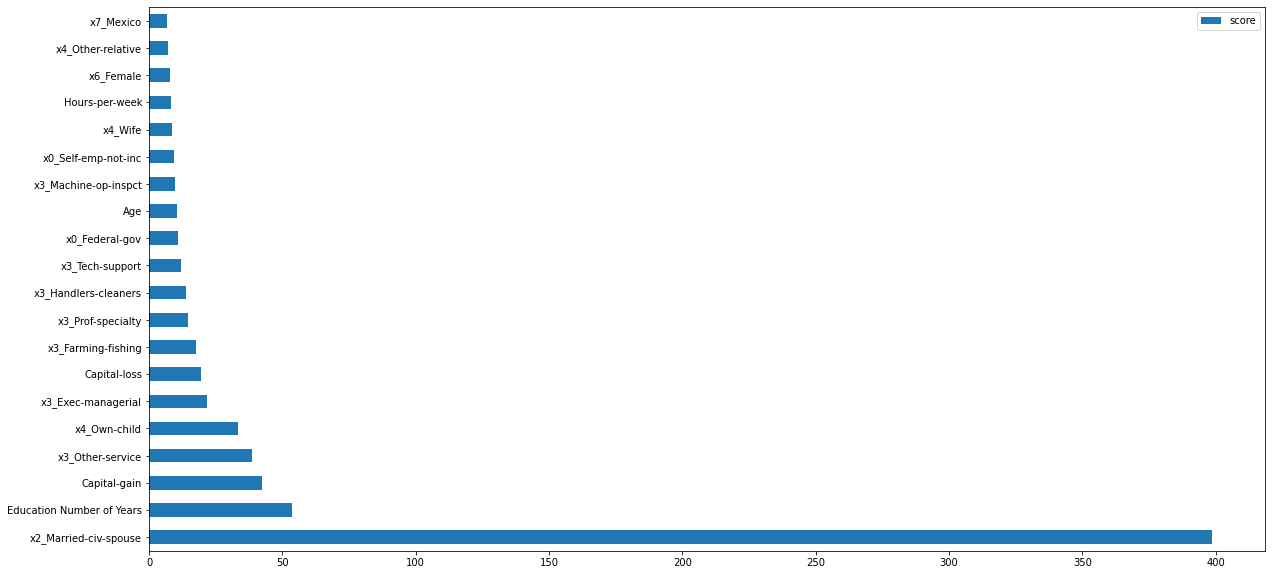

In [ ]:
model=xgb.XGBClassifier(learning_rate=model_pipeline.steps[1][1].best_params_["learning_rate"],
                        max_depth=model_pipeline.steps[1][1].best_params_["max_depth"],
                        n_estimators=model_pipeline.steps[1][1].best_params_["n_estimators"],
                        n_jobs=-1)
model.fit(X_df,y)
feature_important = model.get_booster().get_score(importance_type="gain")
keys = list(feature_important.keys())
values = list(feature_important.values())
data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(20, columns="score").plot(kind='barh', figsize = (20,10)) ## plot top features

In [ ]:
top=10
feature_list=X_df.columns
f_imp=model.feature_importances_
idx = (-f_imp).argsort()[:top]
feats= feature_list[idx].tolist()
print(f"Top {top} features are {feats}")

Top 10 features are ['x2_Married-civ-spouse', 'Education Number of Years', 'Capital-gain', 'x3_Other-service', 'x4_Own-child', 'x3_Exec-managerial', 'Capital-loss', 'x3_Farming-fishing', 'x3_Prof-specialty', 'x3_Handlers-cleaners']


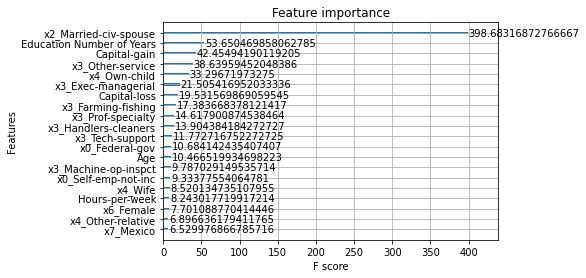

In [ ]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
ax=plot_importance(model, max_num_features = 20,importance_type="gain")
ax.figure.savefig("XGB_feature_importance.png",dpi=350)

# **Evaluate feature importance using RF**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
model=RandomForestClassifier()
name="rf"
grid=grid_rf
# feature transformation for numericals
num_pipeline=Pipeline([("minmax_scaler",MinMaxScaler())])
# apply MinMax to numericals and OneHot to categoricals
transformation_pipeline=ColumnTransformer([("num",num_pipeline,num_ix),
                                           ("cat",OneHotEncoder(handle_unknown = "ignore"),cat_ix)])
# NESTED CROSS-VALIDATION: inner folds for HP search, outer for generaliz.error
# inner kfold for hp-search
inner_kfold=StratifiedKFold(n_splits=3,shuffle=True,random_state=1)
# invoke grid-search CV to search for best hp
gscv= GridSearchCV(estimator=model,
                param_grid = grid,
                cv=inner_kfold,
                scoring='f1',
                verbose=0,
                n_jobs=-1,
                refit=True)
# define model pipeline: data transformation then grid-search
model_pipeline=Pipeline([("transformer",transformation_pipeline),
                         ("model",gscv)])
# fit pipeline on (X_train,y_train) to return best model
model_pipeline.fit(X,y)

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('minmax_scaler',
                                                                   MinMaxScaler())]),
                                                  Index(['Age', 'Final Weight', 'Education Number of Years', 'Capital-gain',
       'Capital-loss', 'Hours-per-week'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['Workclass', 'Education', 'Marital-status', 'Occupation',
       'Relationship', 'Race', 'Sex', 'Native-country'],
      dtype='object'))])),
                ('model',
                 GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=1, shuffle=True),
                              estimator=RandomForestClassifier(), n_jobs=-1,
         

In [ ]:
model=RandomForestClassifier(max_depth=model_pipeline.steps[1][1].best_params_["max_depth"],
                        n_estimators=model_pipeline.steps[1][1].best_params_["n_estimators"],
                        n_jobs=-1)
model.fit(X_df,y)

RandomForestClassifier(n_estimators=300, n_jobs=-1)

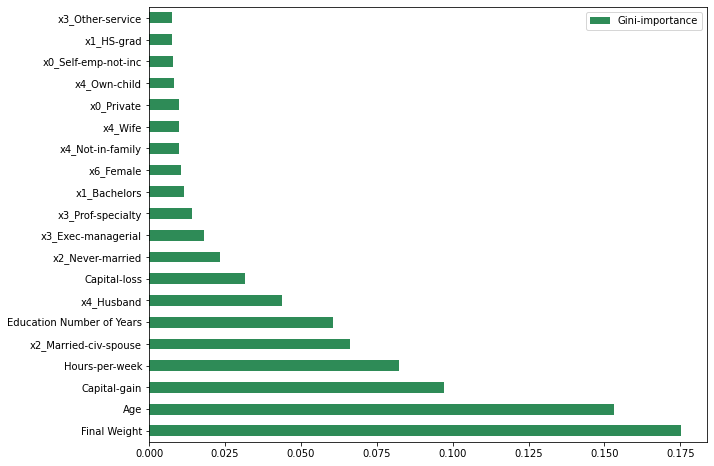

In [ ]:
feats = {}
for feature, importance in zip(X_df.columns, model.feature_importances_):
  feats[feature] = importance #add the name/value pair 
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
ax=importances.sort_values(by='Gini-importance',ascending="False").nlargest(20,columns="Gini-importance").plot(kind='barh', color="SeaGreen",figsize=(10,8))
ax.figure.savefig("RF_feature_importance.png",dpi=350)



---

